## Importing Libraries

- **NumPy**: For numerical operations.
- **PyTorch**: For building and training the model.
- **MobileNet_V2_Weights**: For pre-trained MobileNetV2 weights.
- **DataLoader**: For loading datasets in batches.
- **Torchvision**: For datasets, transformations, and models.
- **Optimizers**: For model optimization (Adam).
- **Scikit-learn**: For calculating the confusion matrix.
- **Matplotlib/Seaborn**: For visualizations.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import MobileNet_V2_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset Directories

- **Training Directory**: `train_dir` contains the training images.
- **Test Directory**: `test_dir` contains the test images.
- **Validation Directory**: `valid_dir` contains the validation images.

In [ ]:
train_dir = "./dataset/train"
test_dir = "./dataset/test"
valid_dir = "./dataset/valid"

## Data Preprocessing and Loading

This section defines the transformations and loads the datasets for training, validation, and testing.

- **Training Transforms**: Resizes, augments (random rotation, flip, crop), converts to tensor, and normalizes.
- **Validation/Test Transforms**: Resizes, converts to tensor, and normalizes.
- **Datasets**: Loaded using `ImageFolder` from the specified directories.
- **Data Loaders**: Batches of size 32 for training, validation, and testing, with shuffling for training.

In [3]:
# Define training data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    # Similar to width and height shifts
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define validation/test data transformations
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Visualizing Sample Images

- **imshow Function**: Denormalizes and displays an image tensor.
- **Data Batch**: Retrieves a batch of images and labels from the training data loader.
- **Visualization**: Displays 6 sample images from the batch with their corresponding labels.
- **Class Names**: Uses `test_data.classes` to print the class labels for each image.

Label: Inclusion


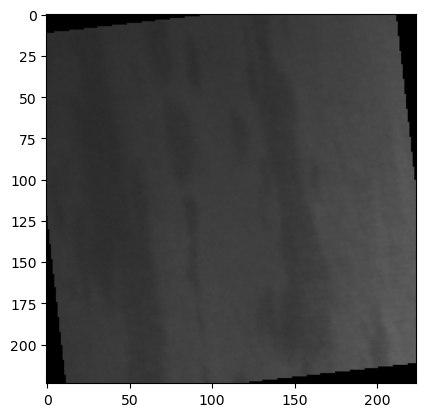

Label: Inclusion


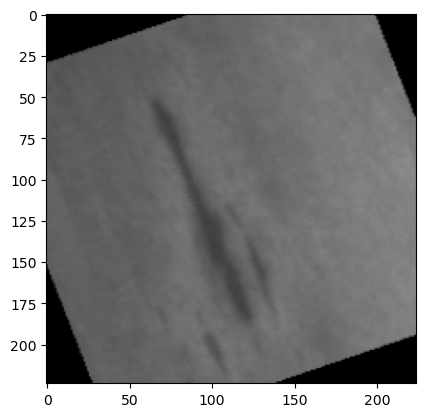

Label: Crazing


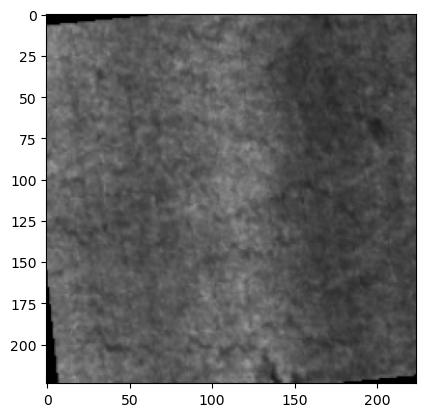

Label: Crazing


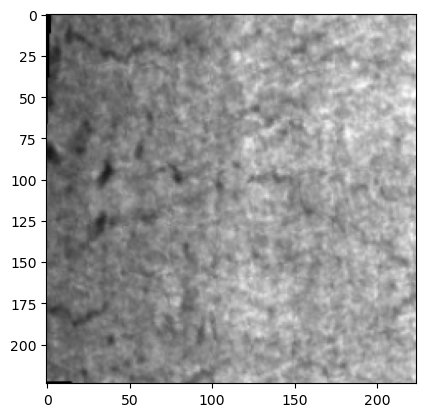

Label: Inclusion


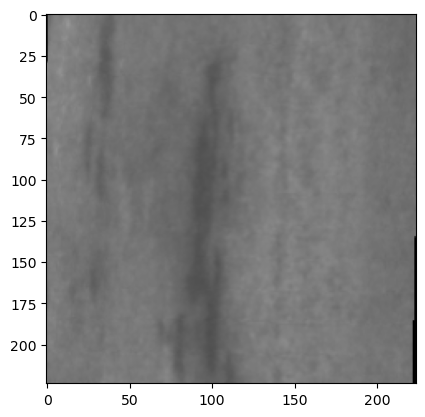

Label: Inclusion


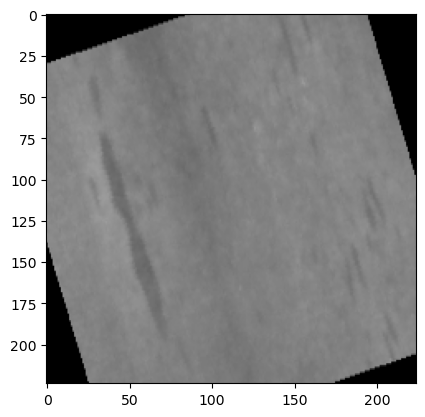

In [ ]:
def imshow(img):
    # Unnormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406])  # ImageNet mean
    std = torch.tensor([0.229, 0.224, 0.225])   # ImageNet std
    img = img * std[:, None, None] + \
        mean[:, None, None]  # Apply unnormalization

    npimg = img.numpy()
    # Ensure values are in [0, 1] range for display
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from CHW to HWC
    plt.show()


# Get a few samples from the training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a few images from the batch
num_samples = 6  # Number of samples to display
for i in range(num_samples):
    print('Label:', test_data.classes[labels[i]])
    imshow(images[i])

## Model Definition and Setup

- **MobileNetV2**: Loads pre-trained MobileNetV2, removes the classifier, and freezes the model parameters.
- **Custom Model**: Adds custom layers (AdaptiveAvgPool, Linear, ReLU, Dropout) for classification.
- **Loss and Optimizer**: Uses CrossEntropyLoss for multi-class classification and Adam optimizer with a learning rate of 0.001.

In [5]:
# Load the MobileNetV2 model, remove the classifier layer, and freeze its parameters
base_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

for param in base_model.parameters():
    param.requires_grad = False

# Define custom model using Sequential for simplicity
model = nn.Sequential(
    base_model.features,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(1280, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 6)
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training and Validation Loop

- **Device Setup**: Configures the model to run on GPU if available.
- **Hyperparameters**: Defines the number of epochs (10), loss function (CrossEntropy), and optimizer (Adam).
- **Metrics**: Tracks training and validation accuracies for each epoch.
- **Training Loop**: 
  - Performs forward and backward passes for training.
  - Updates model weights using the Adam optimizer.
  - Computes and tracks training accuracy.
- **Validation Loop**: Evaluates the model on the validation set without updating weights.
- **Epoch Progress**: Prints training and validation accuracies after each epoch.


In [6]:
# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define number of epochs and other parameters
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training accuracy
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Track validation accuracy
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Accuracy: 0.7325, Validation Accuracy: 0.9444

Epoch [2/10], Train Accuracy: 0.9149, Validation Accuracy: 0.9861

Epoch [3/10], Train Accuracy: 0.9402, Validation Accuracy: 0.9861

Epoch [4/10], Train Accuracy: 0.9450, Validation Accuracy: 1.0000

Epoch [5/10], Train Accuracy: 0.9535, Validation Accuracy: 1.0000

Epoch [6/10], Train Accuracy: 0.9559, Validation Accuracy: 0.9861

Epoch [7/10], Train Accuracy: 0.9577, Validation Accuracy: 0.9861

Epoch [8/10], Train Accuracy: 0.9565, Validation Accuracy: 0.9861

Epoch [9/10], Train Accuracy: 0.9686, Validation Accuracy: 1.0000

Epoch [10/10], Train Accuracy: 0.9680, Validation Accuracy: 1.0000


## Plotting Accuracy

- **Plot**: Visualizes training and validation accuracies over epochs.
- **Axes**: Epochs on the x-axis and accuracy on the y-axis.
- **Legend**: Differentiates between training and validation accuracies.

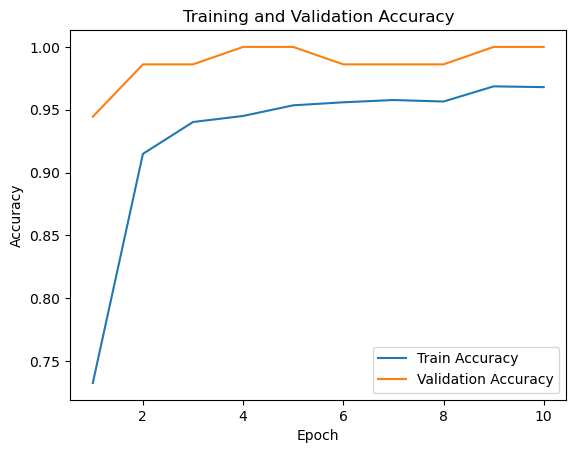

In [7]:
# Plot accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Model Evaluation

- **Evaluation Mode**: Sets the model to evaluation mode (`model.eval()`).
- **Test Loss and Accuracy**: Computes the test loss and accuracy.
- **No Gradient Calculation**: Disables gradient computation with `torch.no_grad()` to speed up evaluation.
- **Test Results**: Outputs the average test loss and accuracy.

In [8]:
# Set model to evaluation mode
model.eval()

# Initialize test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# No gradient computation is needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Accumulate the test loss
        test_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Average the test loss over all batches
test_loss /= total
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0233, Test Accuracy: 1.0000


## Collecting True and Predicted Labels

- **Class Names**: Retrieves class names from the test dataset.
- **Model Evaluation**: Sets the model to evaluation mode and disables gradient computation.
- **True and Predicted Labels**: Collects the true and predicted labels from the test set for later analysis.
- **Conversion**: Converts the labels to numpy arrays for compatibility with `sklearn` functions.

In [9]:
# Get class names from the dataset
class_names = test_data.classes

# Prepare lists to collect true and predicted labels
y_true = []
y_pred = []

# Set model to evaluation mode
model.eval()

# No gradient computation needed
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass to get predictions
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Store true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(y_true)
y_pred = np.array(y_pred)

## Confusion Matrix

- **Compute Confusion Matrix**: Calculates the confusion matrix using true and predicted labels.
- **Plot**: Visualizes the confusion matrix using a heatmap, with class names on both axes.
- **Annotations**: Displays the count of predictions in each cell of the matrix.

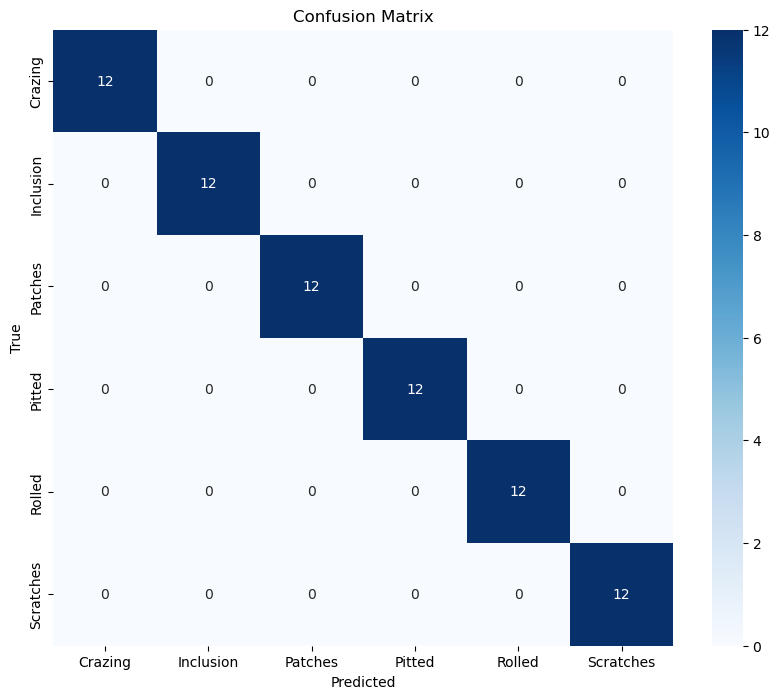

In [10]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()